In [29]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import global_add_pool
from utils.feature_extraction import mol_to_duvenaud_graph
from rdkit import Chem
import matplotlib.pyplot as plt

In [ ]:
class ProbeNGF(nn.Module):
    def __init__(self, in_dim, hidden_dim, fp_dim):
        super().__init__()
        self.W_self  = nn.Linear(in_dim, hidden_dim, bias=True)
        self.W_neigh = nn.Linear(in_dim, hidden_dim, bias=True)
        self.W_fp    = nn.Linear(hidden_dim, fp_dim, bias=False)
    def forward(self, x, edge_index, edge_attr, batch):
        row, col = edge_index
        neigh = torch.zeros_like(x).index_add_(0, row, x[col])
        h = self.W_self(x) + self.W_neigh(neigh)
        return h, self.W_fp(torch.tanh(h))  # return both pre-tanh and pre-softmax activations

In [ ]:
torch.manual_seed(0)
smiles = "CCO"
mol = Chem.MolFromSmiles(smiles)
data = mol_to_duvenaud_graph(mol)
scales = [0.1,1, 10, 100, 1000]
results = []

for scalar in scales:
    print("Testing weight scalar: ", scalar)
    torch.manual_seed(0) 
    probe = ProbeNGF(in_dim=data.x.size(1), hidden_dim=128, fp_dim=2048)
    for name, param in probe.named_parameters():
        if "weight" in name:
            nn.init.normal_(param, mean=0.0, std=scalar)
        elif "bias" in name:
            nn.init.zeros_(param)

    h, u = probe(data.x.float(), data.edge_index, None, data.batch)

    # compute tanh saturation %
    tanh_h = torch.tanh(h)
    #print(tanh_h)
    sat_pct = (tanh_h.abs() > 0.99).float().mean().item()

    # compute softmax peakiness & entropy
    sm = F.softmax(u, dim=1)
    peak   = sm.max(dim=1)[0].mean().item()
    entropy = -(sm * (sm + 1e-8).log()).sum(dim=1).mean().item()

    results.append((scalar, sat_pct, peak, entropy))

print("scale | tanh_sat% | softmax_peak | softmax_entropy")
for scale, sat, peak, ent in results:
    print(f"{scale:6.2f} |    {sat:.3f}   |     {peak:.3f}    |      {ent:.3f}")

Testing weight scalar:  0.1
Testing weight scalar:  1
Testing weight scalar:  10
Testing weight scalar:  100
Testing weight scalar:  1000
scale | tanh_sat% | softmax_peak | softmax_entropy
  0.10 |    0.000   |     0.001    |      7.573
  1.00 |    0.404   |     0.857    |      0.562
 10.00 |    0.935   |     0.980    |      0.076
100.00 |    0.995   |     1.000    |      0.000
1000.00 |    1.000   |     1.000    |      -0.000


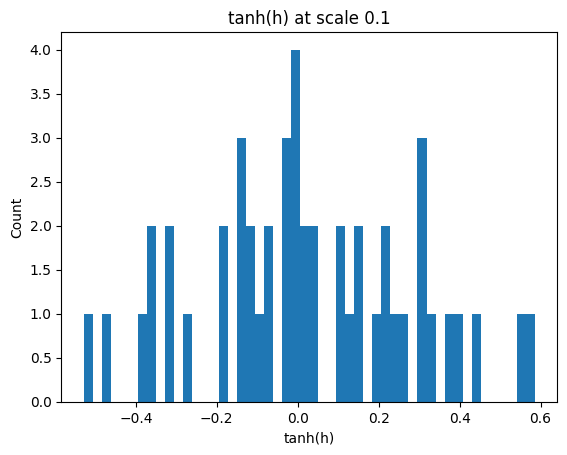

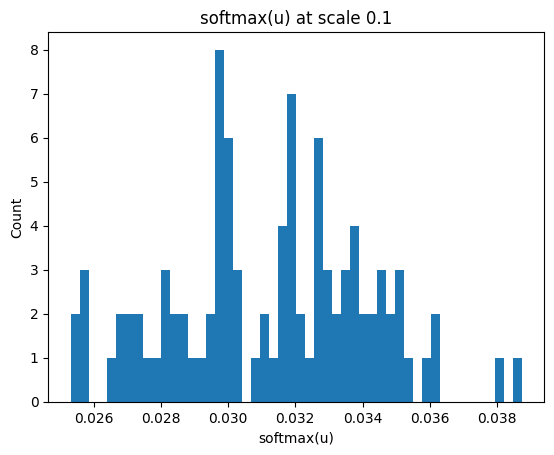

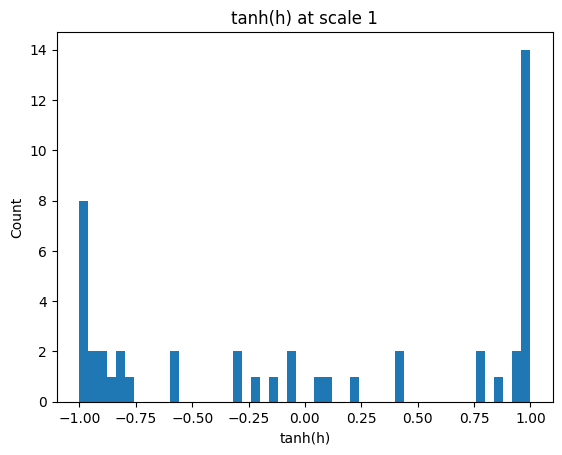

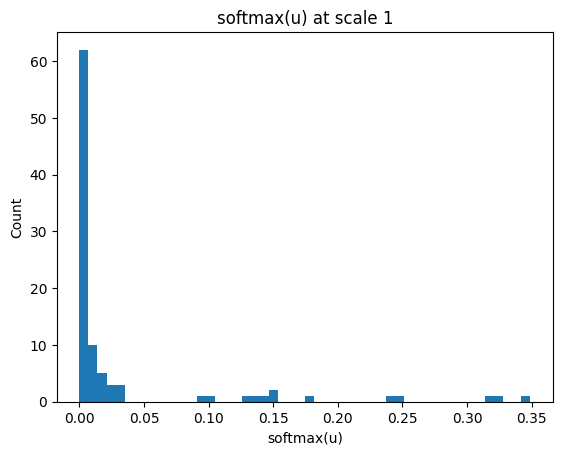

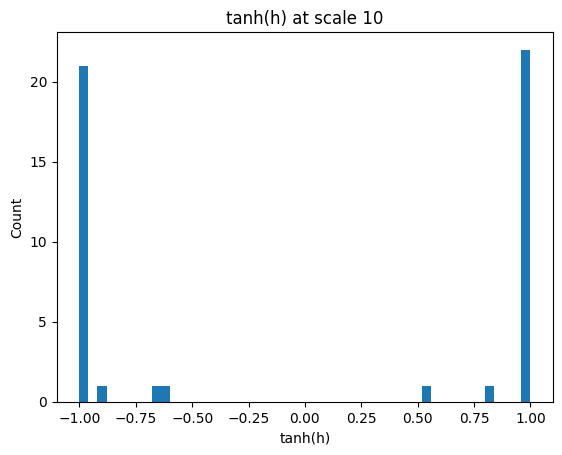

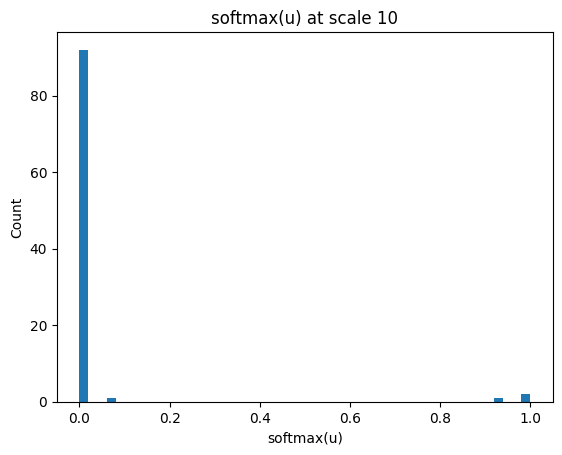

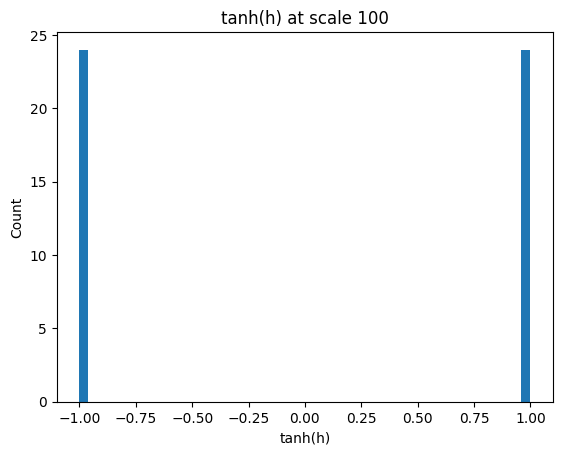

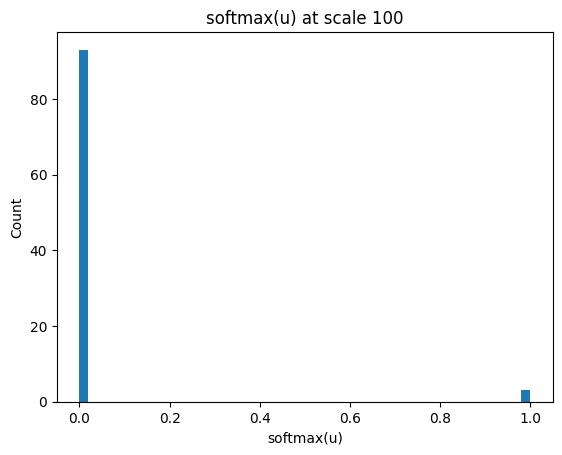

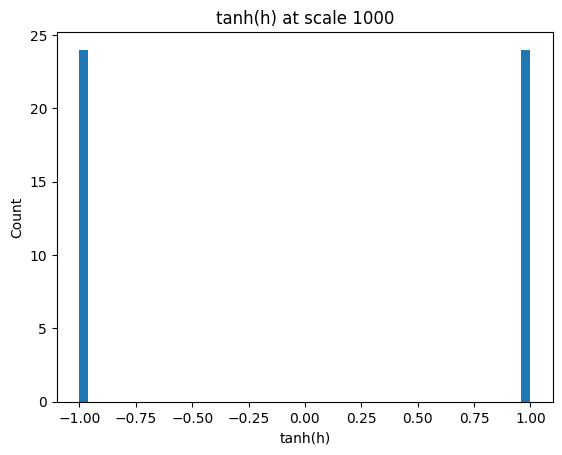

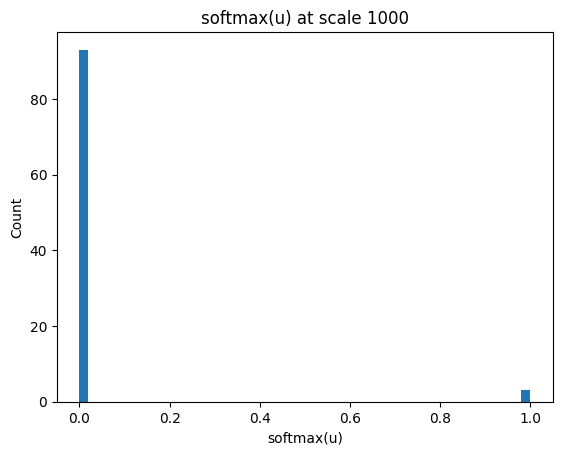

In [ ]:
scales_to_plot = [0.1,1, 10, 100, 1000]
probe = ProbeNGF(in_dim=data.x.size(1), hidden_dim=16, fp_dim=32)

for scale in scales_to_plot:
    torch.manual_seed(0)
    for name, param in probe.named_parameters():
        if "weight" in name:
            nn.init.normal_(param, mean=0.0, std=scale)
        elif "bias" in name:
            nn.init.zeros_(param)
    
    h, u = probe(data.x.float(), data.edge_index, None, data.batch)
    
    # Prepare distributions
    tanh_flat = torch.tanh(h).detach().flatten().numpy()
    sm_flat = F.softmax(u, dim=1).detach().flatten().numpy()
    
    
    # Plot tanh(h)
    plt.figure()
    plt.hist(tanh_flat, bins=50)
    plt.title(f"tanh(h) at scale {scale}")
    plt.xlabel("tanh(h)")
    plt.ylabel("Count")
    plt.show()
    
    # Plot softmax(u)
    plt.figure()
    plt.hist(sm_flat, bins=50)
    plt.title(f"softmax(u) at scale {scale}")
    plt.xlabel("softmax(u)")
    plt.ylabel("Count")
    plt.show()